20240826

**Destilled Vortex Es la ultima version del modelo entrenada SOLO con las variables más importantes**


In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from pycaret.classification import * # Machine learning tools
import imblearn  # Resampling
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import CondensedNearestNeighbour 
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.metrics import ConfusionMatrixDisplay # Model evaluation
import matplotlib.pyplot as plt # Visualization
import seaborn as sns
from sklearn.metrics import classification_report # Model evaluation report
from ipywidgets import widgets # Interactive functions
from sklearn.metrics import classification_report

In [4]:
#Cargamos el dataset desde nuestro directorio de trabajo
#Working directory
#df = pd.read_csv("DATA/20240812_vortex_trainning_float_formmated.csv", encoding='latin-1') 
df = pd.read_excel('./DATA/20240812_vortex_trainning_float_formmated.xlsx', engine='openpyxl')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816 entries, 0 to 1815
Data columns (total 67 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          1816 non-null   object 
 1   Inv. Pieza  1346 non-null   object 
 2   Site        1816 non-null   object 
 3   Contexto    1805 non-null   object 
 4   Contexto 1  0 non-null      float64
 5   Contexto 2  1 non-null      float64
 6   PK_coord    592 non-null    object 
 7   Class       1816 non-null   object 
 8   XRD_code    266 non-null    object 
 9   XRD_path    264 non-null    object 
 10  XRD 1       271 non-null    object 
 11  XRD 2       121 non-null    object 
 12  XRD 3       38 non-null     object 
 13  XRD 4       3 non-null      object 
 14  Group       268 non-null    object 
 15  Subgroup    268 non-null    object 
 16  Hey's CIM   268 non-null    object 
 17  ID_XMET     1814 non-null   object 
 18  Method      1815 non-null   object 
 19  Date XRF    1815 non-null  

In [6]:
# Eliminamos columnas innecesarias para nuestro experimiento
#Some basic Feature engineering
data = df.drop(df.iloc[:, : 22], axis=1)
#Comprobamos que no hay valores faltantes
# Checking missing values
data.isnull().any().any()


False

In [9]:
#data = data.drop(['suma'], axis=1)
data['Site'] = df['Site']

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816 entries, 0 to 1815
Data columns (total 45 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Al      1816 non-null   float64
 1   Si      1816 non-null   float64
 2   P       1816 non-null   float64
 3   S       1816 non-null   float64
 4   Cl      1816 non-null   float64
 5   K       1816 non-null   float64
 6   Ca      1816 non-null   float64
 7   Sc      1816 non-null   float64
 8   Ti      1816 non-null   float64
 9   V       1816 non-null   float64
 10  Cr      1816 non-null   float64
 11  Mn      1816 non-null   float64
 12  Fe      1816 non-null   float64
 13  Co      1816 non-null   float64
 14  Ni      1816 non-null   float64
 15  Cu      1816 non-null   float64
 16  Zn      1816 non-null   float64
 17  Ga      1816 non-null   float64
 18  Ge      1816 non-null   float64
 19  As      1816 non-null   float64
 20  Se      1816 non-null   float64
 21  Br      1816 non-null   float64
 22  

In [ ]:
# 1. Comprobar si hay duplicados
duplicados = data['id'].duplicated().sum()
print(f"Número de ids duplicados: {duplicados}")

# 2. Ver los ids duplicados (si existen)
if duplicados > 0:
    print("IDs duplicados:")
    print(data[data['id'].duplicated(keep=False)]['id'].sort_values())

# 3. Eliminar duplicados, manteniendo la primera aparición
data_sin_duplicados = data.drop_duplicates(subset='id', keep='first')

# 4. Verificar que se eliminaron los duplicados
print(f"Tamaño original de data: {data.shape}")
print(f"Tamaño de data sin duplicados: {data_sin_duplicados.shape}")

# 5. Comprobar nuevamente que no hay duplicados
duplicados_restantes = data_sin_duplicados['id'].duplicated().sum()
print(f"Número de ids duplicados restantes: {duplicados_restantes}")

# 6. Si estás satisfecho con el resultado, puedes asignar el resultado de vuelta a 'data'
data = data_sin_duplicados

# 7. Reiniciar los índices si es necesario
data.reset_index(drop=True, inplace=True)

In [10]:
# Distribución en el target
target = data['Site'].value_counts()
target

CT                     830
PDLC                   511
PCM                    447
SX                       9
MINA TURQUESA/COBRE      9
LEON                     4
SARRABUS                 3
QUINTANA MARCO           2
Zamora                   1
Name: Site, dtype: int64

In [11]:
# Eliminación de casos. Clases <10 para el target_Group
# Case deletion for classes >10
casos = target[target <10]
values = casos.index
values
deleted_cases= data[data['Site'].isin(values)]
case_del = deleted_cases.index
data.drop(case_del, inplace=True)

In [12]:
data['Site'].value_counts()

CT      830
PDLC    511
PCM     447
Name: Site, dtype: int64

In [ ]:
vs1 = pd.read_csv('./DATA/validation_set1.csv')

In [ ]:
vs1= vs1.drop(['Unnamed: 0', 'rand'], axis=1)
vs1.info()

In [ ]:
# Asumiendo que 'data' y 'vs1' son tus DataFrames originales y que ambos tienen una columna 'id'

# 1. Crear data_trainning eliminando las filas de 'data' cuyos 'id' están en 'vs1'
data_trainning = data[~data['id'].isin(vs1['id'])]

# 2. Reiniciar los índices si es necesario
data_trainning.reset_index(drop=True, inplace=True)

# 3. Verificar los resultados
print('Data original shape:', data.shape)
print('Validation set shape:', vs1.shape)
print('Training data shape:', data_trainning.shape)

# 4. Opcionalmente, verificar que no hay ids de vs1 en data_trainning
common_ids = set(data_trainning['id']).intersection(set(vs1['id']))
print('Número de ids comunes (debería ser 0):', len(common_ids))

In [ ]:
data_trainning.Site.value_counts()

In [ ]:
vs1.Site.value_counts()

#### Distilling the knowledge gained from previous iterations: 

We are going to perform a feature selection task based on the previous iterations.

In [13]:
trainning_features = ['S', 'K', 'Ti', 'V', 'Cr', 'Cu', 
                      'Zn', 'As', 'Se', 'Sr', 
                      'Mo','Ba', 
                      'Ta', 'Site']

data = data[trainning_features] 

In [ ]:
['Al', 'Si', 'P', 'S', 'Cl', 'K', 
 'Ca', 'Ti', 'V', 'Cr', 'Fe', 'Ni',
 'Cu', 'Zn', 'As', 'Se', 'Rb', 'Sr', 
 'Zr', 'Mo', 'Ag', 'In', 'Sn', 'Sb',
 'Ba', 'Ta', 'W', 'Tl', 'Site']

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1788 entries, 0 to 1815
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   S       1788 non-null   float64
 1   K       1788 non-null   float64
 2   Ti      1788 non-null   float64
 3   V       1788 non-null   float64
 4   Cr      1788 non-null   float64
 5   Cu      1788 non-null   float64
 6   Zn      1788 non-null   float64
 7   As      1788 non-null   float64
 8   Se      1788 non-null   float64
 9   Sr      1788 non-null   float64
 10  Mo      1788 non-null   float64
 11  Ba      1788 non-null   float64
 12  Ta      1788 non-null   float64
 13  Site    1788 non-null   object 
dtypes: float64(13), object(1)
memory usage: 209.5+ KB


#### Creating our Classification function:


In [15]:
X = data.drop(['Site'], axis=1)
y = data['Site']

In [ ]:
X.info()

In [ ]:
y.value_counts()

#### Data Aumentagtion of minority classes (SMOTE)
We carry out the Synthetic Minority Oversampling Technique

PDLC    830
CT      830
PCM     830
Name: Site, dtype: int64

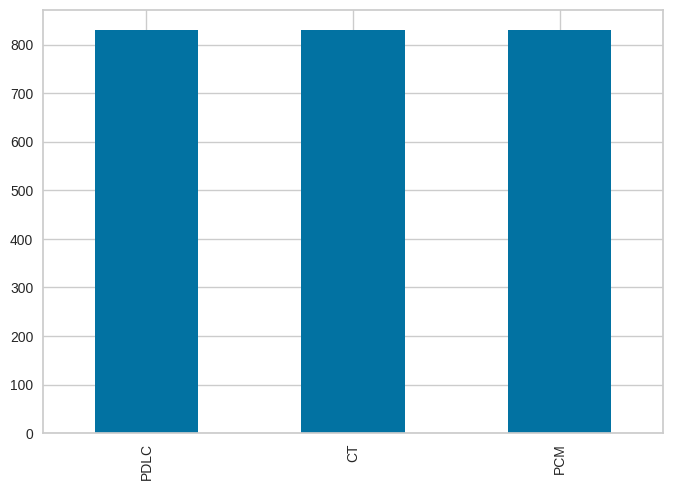

In [16]:
# oversampling strategy
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)

y_smote.value_counts().plot(kind='bar')
#plt.savefig('SMOTE_distribution.png',dpi=200, bbox_inches='tight')
y_smote.value_counts()

In [17]:
# Creating final resampled dataset
smote_data = X_smote
smote_data['Site'] = y_smote

In [18]:
# Final dataset shape after resampling
smote_data.shape
smote_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2490 entries, 0 to 2489
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   S       2490 non-null   float64
 1   K       2490 non-null   float64
 2   Ti      2490 non-null   float64
 3   V       2490 non-null   float64
 4   Cr      2490 non-null   float64
 5   Cu      2490 non-null   float64
 6   Zn      2490 non-null   float64
 7   As      2490 non-null   float64
 8   Se      2490 non-null   float64
 9   Sr      2490 non-null   float64
 10  Mo      2490 non-null   float64
 11  Ba      2490 non-null   float64
 12  Ta      2490 non-null   float64
 13  Site    2490 non-null   object 
dtypes: float64(13), object(1)
memory usage: 272.5+ KB


In [19]:
# Experiment setup 

experiment = setup(data=smote_data, target= 'Site',train_size=0.8, session_id=123)

,Description,Value
0,Session id,123
1,Target,Site
2,Target type,Multiclass
3,Target mapping,"CT: 0, PCM: 1, PDLC: 2"
4,Original data shape,"(2490, 14)"
5,Transformed data shape,"(2490, 14)"
6,Transformed train set shape,"(1992, 14)"
7,Transformed test set shape,"(498, 14)"
8,Numeric features,13
9,Preprocess,True


In [20]:
remove_metric('MCC')
remove_metric('Kappa')
remove_metric('AUC')
#'AUC', , 'MCC'

In [21]:
rf = create_model('rf', class_weight="balanced", criterion='entropy')

,Accuracy,Recall,Prec.,F1
Fold,,,,
0,0.9600,0.9600,0.9619,0.9599
1,0.9350,0.9350,0.9405,0.9355
2,0.9749,0.9749,0.9759,0.9749
3,0.9296,0.9296,0.9294,0.9293
4,0.9648,0.9648,0.9652,0.9649
5,0.9146,0.9146,0.9174,0.9142
6,0.9447,0.9447,0.9450,0.9447
7,0.9698,0.9698,0.9700,0.9698
8,0.9799,0.9799,0.9800,0.9799


In [22]:
tuned_model = tune_model(rf, n_iter=10, tuner_verbose=True, optimize='F1', custom_grid = {'criterion': ['entropy']})

,Accuracy,Recall,Prec.,F1
Fold,,,,
0,0.9600,0.9600,0.9619,0.9599
1,0.9350,0.9350,0.9405,0.9355
2,0.9749,0.9749,0.9759,0.9749
3,0.9296,0.9296,0.9294,0.9293
4,0.9648,0.9648,0.9652,0.9649
5,0.9146,0.9146,0.9174,0.9142
6,0.9447,0.9447,0.9450,0.9447
7,0.9698,0.9698,0.9700,0.9698
8,0.9799,0.9799,0.9800,0.9799


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Model Calibration:
This function calibrates the probability of a given estimator using isotonic or logistic regression. The output of this function is a score grid with CV scores by fold.
By default function uses Logistic regression model to transform probabilities.
We chose this method to take into account the following library documentation [warning](https://pycaret.readthedocs.io/en/latest/api/classification.html#pycaret.classification.calibrate_model) and avoid overfitting. 


In [23]:
cal_model = calibrate_model(tuned_model)
cal_model

,Accuracy,Recall,Prec.,F1
Fold,,,,
0,0.9500,0.9500,0.9527,0.9499
1,0.9150,0.9150,0.9208,0.9155
2,0.9648,0.9648,0.9662,0.9648
3,0.9246,0.9246,0.9246,0.9245
4,0.9648,0.9648,0.9648,0.9648
5,0.9196,0.9196,0.9219,0.9194
6,0.9447,0.9447,0.9451,0.9446
7,0.9648,0.9648,0.9648,0.9648
8,0.9698,0.9698,0.9699,0.9698


CalibratedClassifierCV(cv=5, ensemble=True,
                       estimator=RandomForestClassifier(bootstrap=True,
                                                        ccp_alpha=0.0,
                                                        class_weight='balanced',
                                                        criterion='entropy',
                                                        max_depth=None,
                                                        max_features='sqrt',
                                                        max_leaf_nodes=None,
                                                        max_samples=None,
                                                        min_impurity_decrease=0.0,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        monotonic_cst=None,
                                                        n_estimators=100,
                                                        n_jobs=-1,
                                                        oob_score=False,
                                                        random_state=123,
                                                        verbose=0,
                                                        warm_start=False),
                       method='sigmoid', n_jobs=None)

In [25]:
X_test = get_config(variable="X_test")
y_test = get_config(variable="y_test")
y_test.value_counts()

CT      166
PCM     166
PDLC    166
Name: Site, dtype: int64

In [26]:
#The calibrated model evaluated against test data
last_training_predictions = predict_model(cal_model)

y_true = y_test
y_pred = last_training_predictions['prediction_label']
class_rep = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).T
#class_rep.to_csv('./TABLES/20240826_classificationReportDestilledVortexTestData.csv')
class_rep


,Model,Accuracy,Recall,Prec.,F1
0,Random Forest Classifier,0.9699,0.9699,0.9703,0.9699


,precision,recall,f1-score,support
CT,0.947368,0.975904,0.961424,166.00000
PCM,0.975904,0.975904,0.975904,166.00000
PDLC,0.987578,0.957831,0.972477,166.00000
accuracy,0.969880,0.969880,0.969880,0.96988
macro avg,0.970283,0.969880,0.969935,498.00000
weighted avg,0.970283,0.969880,0.969935,498.00000


In [27]:
final_model = finalize_model(cal_model)


In [28]:
unseen_predictions = predict_model(final_model, data=vs1)
unseen_predictions

NameError: name 'vs1' is not defined

In [ ]:
y_true_vs1 = unseen_predictions['Site']
y_pred_vs1 = unseen_predictions['prediction_label']
class_rep_vs1 = pd.DataFrame(classification_report(y_true_vs1, y_pred_vs1, output_dict=True)).T
#class_rep_vs1.to_csv('./TABLES/20240920_classificationReportFVS1DestilledVortex.csv')
class_rep_vs1

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true_vs1,y_pred_vs1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= ['Garraf', 'Terena', 'Aliste'])
disp.plot(cmap='Greens')
#plt.savefig("./FIGURES/20240826_DestilledVortex2VS1_ConfMatrix.png",bbox_inches='tight')


### Save the Model
This function saves the transformation pipeline and trained model object into the current working directory as a pickle file for later use.

In [29]:
save_model(final_model, model_name = './20250217_VortexDestilled13elementsSinCa',verbose=True)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['S', 'K', 'Ti', 'V', 'Cr', 'Cu',
                                              'Zn', 'As', 'Se', 'Sr', 'Mo', 'Ba',
                                              'Ta'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_...
                                                                          class_weight='balanced',
                                                         